# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [15]:
import numpy as np
from PIL import Image
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt
from skimage import io
import cv2
from imageio import imread

We set the random seed so that the results don't vary drastically.

In [16]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [17]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
#print(train_doc)

In [18]:
# # Number of videos in training
# print(train_doc.shape[0])
# # Number of videos in validation
# print(val_doc.shape)
batch_size = 48

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [19]:
def generator(source_path, folder_list, batch_size,no_of_frames):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    print(len(folder_list))
    img_idx = list(range(1,30,3))#create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list)//batch_size) # 663/10=66 batches
        #rem_videos= (train_doc.shape[0]%batch_size) # 3 videos
        for batch in range(num_batches): # we iterate over the number of batches
            x=no_of_frames
            y=100
            z=100            
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image,(100,100))
                    image=image.astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
            
            # write the code for the remaining data points which are left after full batches
            
        if (len(folder_list) > batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            #batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            #batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = cv2.resize(image,(100,100))
                    image=image.astype(np.float32)
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])#normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])#normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])#normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do  


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [20]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 7
print ('# epochs =', num_epochs)
input_shape=(10,100,100,3)
input_shape
# num_classes=5
# num_classes

# training sequences = 663
# validation sequences = 100
# epochs = 7


(10, 100, 100, 3)

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [21]:
# CONV3D Model
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

#write your model here

num_classes = 5
model = Sequential()

model.add(Conv3D(32, kernel_size=(2,2,2),activation='relu',padding='same',input_shape=input_shape)) # input shape = (img_rows, img_cols, 1)
# model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.24))

# second conv layer
model.add(Conv3D(64, kernel_size=(2,2,2),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.18)) 

model.add(Conv3D(128, kernel_size=(2,2,2),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.18)) 


# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(BatchNormalization())
model.add(Dropout(0.26))
# softmax layer
model.add(Dense(num_classes))
model.add(Activation('softmax'))

optimiser = optimizers.Adam(lr=0.01);#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 10, 100, 100, 32)  800       
_________________________________________________________________
batch_normalization_5 (Batch (None, 10, 100, 100, 32)  128       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 5, 50, 50, 32)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 50, 50, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 50, 50, 64)     16448     
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 50, 50, 64)     256       
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 2, 25, 25, 64)     0         
__________

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [22]:
no_of_frames=10
train_generator = generator(train_path, train_doc, batch_size,no_of_frames)
val_generator = generator(val_path, val_doc, batch_size,no_of_frames)


In [23]:
# train_generator.shape

In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1,min_lr=0.0001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [26]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data/val ; batch size = 48
100
Source path =  Epoch 1/7
Project_data/train ; batch size = 48
663
14/14 [==============================] - 24s 2s/step - loss: 1.7189 - categorical_accuracy: 0.4241 - val_loss: 4.7039 - val_categorical_accuracy: 0.2569

Epoch 00001: val_loss improved from inf to 4.70386, saving model to model_init_2020-05-0411_59_51.570587/model-00001-1.71891-0.42411-4.70386-0.25694.h5
Epoch 2/7
14/14 [==============================] - 15s 1s/step - loss: 0.8993 - categorical_accuracy: 0.6758 - val_loss: 2.0732 - val_categorical_accuracy: 0.5000

Epoch 00002: val_loss improved from 4.70386 to 2.07318, saving model to model_init_2020-05-0411_59_51.570587/model-00002-0.89927-0.67582-2.07318-0.50000.h5
Epoch 3/7
14/14 [==============================] - 16s 1s/step - loss: 0.6807 - categorical_accuracy: 0.7418 - val_loss: 1.9411 - val_categorical_accuracy: 0.5000

Epoch 00003: val_loss improved from 2.07318 to 1.94108, saving model to model_init_2020-05

In [27]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


Text(0.5, 1.0, 'Accuracy Curves')

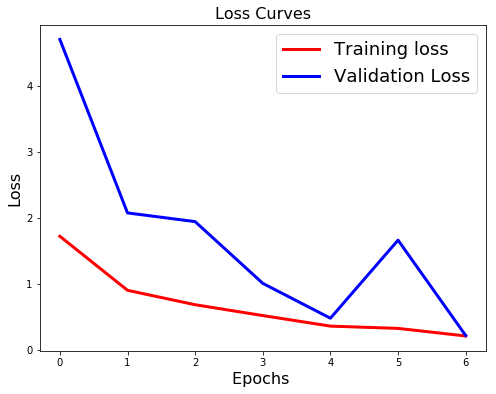

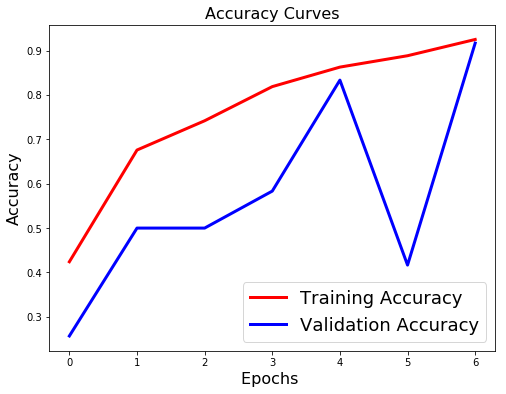

In [28]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)